# Thickness Above Adjusted Replacement (TAAR) and Percent Thickness Above Adjusted Replacement (PTAAR)

In [255]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from nba_api.stats.endpoints import LeagueDashPlayerBioStats

## Motivation
Reddit [post](https://www.reddit.com/r/nba/comments/jckli9/the_cleveland_cavaliers_are_thick_as_hell/) by u/cgilbert0812

In [276]:
bio = LeagueDashPlayerBioStats(season='2019-20').get_data_frames()[0]

In [321]:
df = bio[['PLAYER_NAME', 'TEAM_ABBREVIATION', 'PLAYER_HEIGHT_INCHES', 'PLAYER_WEIGHT']].copy()
df.columns = [ col.lower() for col in df.columns ]

In [322]:
df.head()

,player_name,team_abbreviation,player_height_inches,player_weight
0,Aaron Gordon,ORL,80,235
1,Aaron Holiday,IND,72,185
2,Abdel Nader,OKC,77,225
3,Adam Mokoka,CHI,77,190
4,Admiral Schofield,WAS,77,241


In [324]:
# Convert weight column to integers
df['player_weight'] = df['player_weight'].astype('int')

In [325]:
# Height range
h_range = np.arange(x.min(), x.max() + 1).reshape((-1,1))

In [326]:
# Function to get average weight at each height value
def get_avg(x):
    average = df['player_weight'].loc[np.where(df['player_height_inches'] == x)].mean()
    return average

In [344]:
# Dictionary for mapping player height -> average weight
avg_weight = { int(h_range[i]): get_avg(int(h_range[i])) for i in range(len(h_range)) }

In [345]:
# Map dictionary
df['avg_weight'] = df['player_height_inches'].map(avg_weight)

# Add TAR column
df['TAR'] = df['player_weight'] - df['avg_weight']

## TAR vs. TAAR
Issue: Average player weight is not increasing as a function of height.  This could be a result of small sample size at each height.

Solution: Adjusted average based on polynomial linear regression.

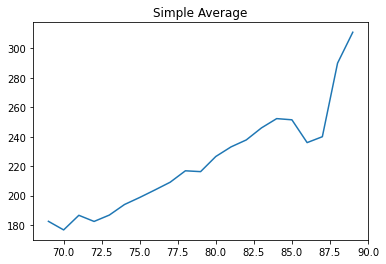

In [389]:
plt.plot(h_range, avg_weight.values())
plt.title('Simple Average')
plt.show()

In [360]:
x = np.array(df['player_height_inches']).reshape((-1,1))
y = df['player_weight']

In [379]:
# Simple linear model of weight as a function of height
model = LinearRegression().fit(x, y)

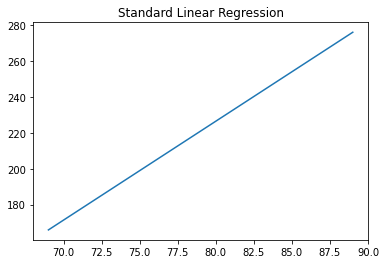

In [380]:
preds = model.predict(h_range)
plt.plot(h_range, preds)
plt.title('Standard Linear Regression')
plt.show()

In [381]:
transformer = PolynomialFeatures(degree=2)
X = transformer.fit_transform(x)

In [382]:
# Polynomial model
model = LinearRegression().fit(X, y)

In [383]:
X_ = transformer.transform(h_range.reshape((-1,1)))
preds = model.predict(X_)

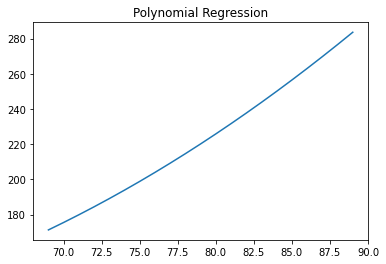

In [384]:
plt.plot(h_range, preds)
plt.title('Polynomial Regression')
plt.show()

In [385]:
# Creating dictionary from polynomial model
reg = { int(h_range[i]): preds[i] for i in range(len(h_range)) }

In [386]:
# Create a predicted weight
df['predicted_weight'] = df['player_height_inches'].map(lambda x: reg[x])

# Add column for difference between "adjusted average"
df['TAAR'] = df['player_weight'] - df['predicted_weight']

In [387]:
df.head()

,player_name,team_abbreviation,player_height_inches,player_weight,avg_weight,TAR,predicted_weight,TAAR
0,Aaron Gordon,ORL,80,235,226.568966,8.431034,225.834053,9.165947
1,Aaron Holiday,IND,72,185,182.428571,2.571429,184.390905,0.609095
2,Abdel Nader,OKC,77,225,209.079365,15.920635,209.198190,15.801810
3,Adam Mokoka,CHI,77,190,209.079365,-19.079365,209.198190,-19.198190
4,Admiral Schofield,WAS,77,241,209.079365,31.920635,209.198190,31.801810


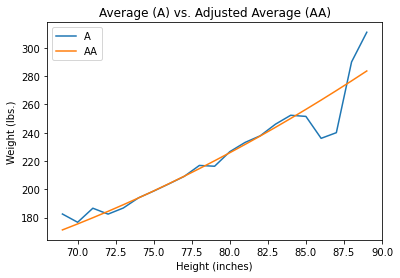

In [388]:
plt.plot(h_range, avg_weight.values(), h_range, preds)
plt.title('Average (A) vs. Adjusted Average (AA)')
plt.xlabel('Height (inches)')
plt.ylabel('Weight (lbs.)')

labels = ['A', 'AA']
plt.legend(labels)

plt.show()

#### Note:
Small sample size under/over penalized players at certain heights

In [399]:
df.loc[df['player_height_inches'] == 85]

,player_name,team_abbreviation,player_height_inches,player_weight,avg_weight,TAR,predicted_weight,TAAR
213,Jakob Poeltl,SAS,85,245,251.5,-6.5,256.479642,-11.479642
436,Rudy Gobert,UTA,85,258,251.5,6.5,256.479642,1.520358


In [398]:
df.loc[df['player_height_inches'] == 86]

,player_name,team_abbreviation,player_height_inches,player_weight,avg_weight,TAR,predicted_weight,TAAR
26,Anzejs Pasecniks,WAS,86,229,236.0,-7.0,263.046632,-34.046632
40,Bol Bol,DEN,86,220,236.0,-16.0,263.046632,-43.046632
337,Luke Kornet,CHI,86,250,236.0,14.0,263.046632,-13.046632
382,Moses Brown,POR,86,245,236.0,9.0,263.046632,-18.046632


## PTAAR

In [414]:
df['PTAAR'] = df['TAAR'] / df['predicted_weight']

In [392]:
df.sort_values('TAR', ascending=False).head(10)

,player_name,team_abbreviation,player_height_inches,player_weight,avg_weight,TAR,predicted_weight,TAAR
527,Zion Williamson,NOP,78,284,216.839286,67.160714,214.597520,69.402480
17,Andre Drummond,CLE,82,279,237.804878,41.195122,237.654415,41.345585
226,Jarrell Brantley,UTA,77,250,209.079365,40.920635,209.198190,40.801810
414,Paul Millsap,DEN,79,257,216.274510,40.725490,220.142808,36.857192
159,Eric Paschall,GSW,78,255,216.839286,38.160714,214.597520,40.402480
284,Jusuf Nurkic,POR,84,290,252.304348,37.695652,250.058609,39.941391
512,Wendell Carter Jr.,CHI,81,270,233.093023,36.906977,231.671255,38.328745
120,Deonte Burton,OKC,76,240,203.833333,36.166667,203.944818,36.055182
404,P.J. Tucker,HOU,77,245,209.079365,35.920635,209.198190,35.801810
211,Jahlil Okafor,NOP,82,270,237.804878,32.195122,237.654415,32.345585


In [393]:
df.sort_values('TAAR', ascending=False).head(10)

,player_name,team_abbreviation,player_height_inches,player_weight,avg_weight,TAR,predicted_weight,TAAR
527,Zion Williamson,NOP,78,284,216.839286,67.160714,214.597520,69.402480
17,Andre Drummond,CLE,82,279,237.804878,41.195122,237.654415,41.345585
226,Jarrell Brantley,UTA,77,250,209.079365,40.920635,209.198190,40.801810
159,Eric Paschall,GSW,78,255,216.839286,38.160714,214.597520,40.402480
284,Jusuf Nurkic,POR,84,290,252.304348,37.695652,250.058609,39.941391
512,Wendell Carter Jr.,CHI,81,270,233.093023,36.906977,231.671255,38.328745
414,Paul Millsap,DEN,79,257,216.274510,40.725490,220.142808,36.857192
120,Deonte Burton,OKC,76,240,203.833333,36.166667,203.944818,36.055182
404,P.J. Tucker,HOU,77,245,209.079365,35.920635,209.198190,35.801810
395,Nikola Jokic,DEN,84,284,252.304348,31.695652,250.058609,33.941391


In [417]:
df.sort_values('PTAAR', ascending=False).head(10)

,player_name,team_abbreviation,player_height_inches,player_weight,avg_weight,TAR,predicted_weight,TAAR,PTAAR
527,Zion Williamson,NOP,78,284,216.839286,67.160714,214.597520,69.402480,0.323408
226,Jarrell Brantley,UTA,77,250,209.079365,40.920635,209.198190,40.801810,0.195039
159,Eric Paschall,GSW,78,255,216.839286,38.160714,214.597520,40.402480,0.188271
120,Deonte Burton,OKC,76,240,203.833333,36.166667,203.944818,36.055182,0.176789
17,Andre Drummond,CLE,82,279,237.804878,41.195122,237.654415,41.345585,0.173974
404,P.J. Tucker,HOU,77,245,209.079365,35.920635,209.198190,35.801810,0.171138
414,Paul Millsap,DEN,79,257,216.274510,40.725490,220.142808,36.857192,0.167424
512,Wendell Carter Jr.,CHI,81,270,233.093023,36.906977,231.671255,38.328745,0.165445
284,Jusuf Nurkic,POR,84,290,252.304348,37.695652,250.058609,39.941391,0.159728
4,Admiral Schofield,WAS,77,241,209.079365,31.920635,209.198190,31.801810,0.152018


In [420]:
ptaar = df.groupby('team_abbreviation')['PTAAR'].mean().sort_values(ascending=False).reset_index()

In [405]:
tar = df.groupby('team_abbreviation')['TAR'].mean().sort_values(ascending=False).reset_index().copy()
taar = df.groupby('team_abbreviation')['TAAR'].mean().sort_values(ascending=False).reset_index().copy()

In [409]:
tar.head(10)

,team_abbreviation,TAR
0,CLE,8.934780
1,BOS,7.269576
2,MIL,6.790412
3,UTA,6.402809
4,NOP,4.460182
5,LAL,3.780160
6,DEN,3.229698
7,NYK,1.801937
8,HOU,1.367544
9,PHI,1.204847


In [410]:
taar.head(10)

,team_abbreviation,TAAR
0,BOS,9.641985
1,CLE,8.268791
2,MIL,7.250325
3,UTA,5.332562
4,NOP,4.764957
5,LAL,4.215293
6,HOU,2.503157
7,NYK,1.900509
8,DEN,1.745556
9,PHI,1.334542


In [422]:
ptaar.head(10)

,team_abbreviation,PTAAR
0,BOS,0.045038
1,CLE,0.035876
2,MIL,0.032854
3,UTA,0.025836
4,NOP,0.021743
5,LAL,0.017493
6,HOU,0.013532
7,NYK,0.009174
8,DEN,0.007707
9,MIN,0.006055
